In [1]:
import numpy as np
import pandas as pd

import os
import string
from string import digits
import matplotlib.pyplot as plt
%matplotlib inline
import re
from numpy import array, argmax, random, take

import seaborn as sns
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from keras.layers import Input, LSTM, Embedding, Dense, RepeatVector, TimeDistributed, Activation
from keras.models import Model
from keras.preprocessing.text import Tokenizer
from keras.callbacks import ModelCheckpoint
from keras.preprocessing.sequence import pad_sequences
from tensorflow.keras import optimizers

print(os.listdir("../input"))

['wikisql']


In [2]:
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
pd.set_option('display.max_colwidth', -1)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:4: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  after removing the cwd from sys.path.


In [3]:
df=pd.read_csv("../input/wikisql/train.csv",encoding='utf-8')

In [4]:
df.head(15)

,question,sql
0,Tell me what the notes are for South Australia,SELECT Notes FROM table WHERE Current slogan = SOUTH AUSTRALIA
1,What is the current series where the new series began in June 2011?,SELECT Current series FROM table WHERE Notes = New series began in June 2011
2,What is the format for South Australia?,SELECT Format FROM table WHERE State/territory = South Australia
3,Name the background colour for the Australian Capital Territory,SELECT Text/background colour FROM table WHERE State/territory = Australian Capital Territory
4,how many times is the fuel propulsion is cng?,SELECT COUNT Fleet Series (Quantity) FROM table WHERE Fuel Propulsion = CNG
5,what is the fuel propulsion where the fleet series (quantity) is 310-329 (20)?,SELECT Fuel Propulsion FROM table WHERE Fleet Series (Quantity) = 310-329 (20)
6,who is the manufacturer for the order year 1998?,SELECT Manufacturer FROM table WHERE Order Year = 1998
7,how many times is the model ge40lfr?,SELECT COUNT Manufacturer FROM table WHERE Model = GE40LFR
8,how many times is the fleet series (quantity) is 468-473 (6)?,SELECT COUNT Order Year FROM table WHERE Fleet Series (Quantity) = 468-473 (6)
9,what is the powertrain (engine/transmission) when the order year is 2000?,SELECT Powertrain (Engine/Transmission) FROM table WHERE Order Year = 2000


In [5]:
df.rename(columns = {'question':'question', 'sql':'sql'}, inplace = True)

pd.isnull(df).sum()

question    0
sql         0
dtype: int64

In [6]:
df.drop_duplicates(inplace=True)

In [7]:
df=df.sample(n=20000,random_state=42)
df.shape

(20000, 2)

In [8]:
# Lowercase all characters
df['question']=df['question'].apply(lambda x: x.lower())
df['sql']=df['sql'].apply(lambda x: x.lower())

In [9]:
# Remove extra spaces
df['question']=df['question'].apply(lambda x: x.strip())
df['sql']=df['sql'].apply(lambda x: x.strip())
df['question']=df['question'].apply(lambda x: re.sub(" +", " ", x))
df['sql']=df['sql'].apply(lambda x: re.sub(" +", " ", x))

In [10]:
df.head()

,question,sql
43648,how much is the purse worth (¥) after 2012?,select sum purse (¥) from table where year > 2012
46173,what is the name for malay with a foundation in iptura?,select name in malay from table where foundation = iptura
19352,what is the highest weight for the farnley stakes race?,select max weight (kg) from table where race = farnley stakes
3130,what are the won games with losing bonus of 0?,select won from table where losing bonus = 0
3192,what's the airport with % change 2005/2006 being 13.0%,select airport from table where % change 2005/2006 = 13.0%


In [11]:
# Add start and end tokens to target sequences
df['sql'] = df['sql'].apply(lambda x : 'start_ '+ x + ' _end')

In [12]:
df.head()

,question,sql
43648,how much is the purse worth (¥) after 2012?,start_ select sum purse (¥) from table where year > 2012 _end
46173,what is the name for malay with a foundation in iptura?,start_ select name in malay from table where foundation = iptura _end
19352,what is the highest weight for the farnley stakes race?,start_ select max weight (kg) from table where race = farnley stakes _end
3130,what are the won games with losing bonus of 0?,start_ select won from table where losing bonus = 0 _end
3192,what's the airport with % change 2005/2006 being 13.0%,start_ select airport from table where % change 2005/2006 = 13.0% _end


In [13]:
### Get question and sql Vocabulary
all_eng_words=set()
for eng in df['question']:
    for word in eng.split():
        if word not in all_eng_words:
            all_eng_words.add(word)

all_sql_words=set()
for sql in df['sql']:
    for word in sql.split():
        if word not in all_sql_words:
            all_sql_words.add(word)

In [14]:
len(all_eng_words)

26475

In [15]:
len(all_sql_words)

21200

In [16]:
df['length_question_sentence']=df['question'].apply(lambda x:len(x.split(" ")))
df['length_sql_sentence']=df['sql'].apply(lambda x:len(x.split(" ")))

In [17]:
df.head()

,question,sql,length_question_sentence,length_sql_sentence
43648,how much is the purse worth (¥) after 2012?,start_ select sum purse (¥) from table where year > 2012 _end,9,12
46173,what is the name for malay with a foundation in iptura?,start_ select name in malay from table where foundation = iptura _end,11,12
19352,what is the highest weight for the farnley stakes race?,start_ select max weight (kg) from table where race = farnley stakes _end,10,13
3130,what are the won games with losing bonus of 0?,start_ select won from table where losing bonus = 0 _end,10,11
3192,what's the airport with % change 2005/2006 being 13.0%,start_ select airport from table where % change 2005/2006 = 13.0% _end,5,12


In [18]:
print("Maximum length of SQL Sentence ",max(df['length_sql_sentence']))
print("Maximum length of English Sentence ",max(df['length_question_sentence']))

Maximum length of SQL Sentence  84
Maximum length of English Sentence  44


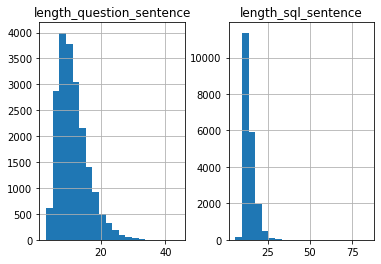

In [19]:
import matplotlib.pyplot as plt

df[['length_question_sentence', 'length_sql_sentence']].hist(bins = 20)
plt.show()

In [20]:
max_length_src=20
max_length_tar=25

In [21]:
df.shape

(20000, 4)

In [22]:
text2sql = array(df)

In [23]:
text2sql

array([['how much is the purse worth (¥) after 2012?',
        'start_ select sum purse (¥) from table where year > 2012 _end',
        9, 12],
       ['what is the name for malay with a foundation in iptura?',
        'start_ select name in malay from table where foundation = iptura _end',
        11, 12],
       ['what is the highest weight for the farnley stakes race?',
        'start_ select max weight (kg) from table where race = farnley stakes _end',
        10, 13],
       ...,
       ["what's the stadium on november 8?",
        'start_ select home from table where date = november 8 _end', 6,
        11],
       ['when 20 is the rank and north west is the region/province what is the county?',
        'start_ select county from table where region/province = north west and rank = 20 _end',
        15, 15],
       ['what was the record of the match that had a time of 1:44?',
        'start_ select record from table where time = 1:44 _end', 13, 10]],
      dtype=object)

**Split train and validation data**

In [24]:
X, y = df['question'], df['sql']
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, shuffle=True,
                                                    random_state=42)
X_train.shape, X_val.shape

((16000,), (4000,))

In [25]:
eng_tokenizer = Tokenizer() 
eng_tokenizer.fit_on_texts(list(X_train))
# minimum frequency for common word category
thresh=4

rare_word_cnt=0
tot_cnt=0
rare_word_freq=0
tot_freq=0

for key, value in eng_tokenizer.word_counts.items():
    tot_cnt = tot_cnt+1
    tot_freq = tot_freq+value
    if(value<thresh):
        rare_word_cnt = rare_word_cnt+1
        rare_word_freq = rare_word_freq+value
    
print("% of rare words in vocabulary:",(rare_word_cnt/tot_cnt)*100)
print("Total Coverage of rare words:",(rare_word_freq/tot_freq)*100)


% of rare words in vocabulary: 81.51009543595403
Total Coverage of rare words: 8.685943135117


In [26]:
eng_tokenizer = Tokenizer(num_words = tot_cnt)
eng_tokenizer.fit_on_texts(list(X_train))

# convert text sequences into integer sequences 
x_tr_seq    =   eng_tokenizer.texts_to_sequences(X_train) 
x_val_seq   =   eng_tokenizer.texts_to_sequences(X_val)

# padding zero upto maximum length
x_tr    =   pad_sequences(x_tr_seq,  maxlen=max_length_src, padding='post')
x_val   =   pad_sequences(x_val_seq, maxlen=max_length_src, padding='post')

# size of vocabulary ( +1 for padding token as it is not present in tokenizer vocab)
english_voc   =  eng_tokenizer.num_words + 1

print("Size of vocabulary in X = {}".format(english_voc))

Size of vocabulary in X = 15404


In [27]:
# prepare a tokenizer on training data
sql_tokenizer = Tokenizer() 
sql_tokenizer.fit_on_texts(list(y_train))

# minimum frequency for common word category
thresh=4

rare_word_cnt=0
tot_cnt=0
rare_word_freq=0
tot_freq=0

for key, value in sql_tokenizer.word_counts.items():
    tot_cnt = tot_cnt+1
    tot_freq = tot_freq+value
    if(value<thresh):
        rare_word_cnt = rare_word_cnt+1
        rare_word_freq = rare_word_freq+value
    
print("% of rare words in vocabulary:",(rare_word_cnt/tot_cnt)*100)
print("Total Coverage of rare words:",(rare_word_freq/tot_freq)*100)

% of rare words in vocabulary: 81.1533347330114
Total Coverage of rare words: 7.645065755205104


In [28]:
# prepare a tokenizer as per above count on training data
sql_tokenizer = Tokenizer(num_words = tot_cnt)
sql_tokenizer.fit_on_texts(list(y_train))

# convert text sequences into integer sequences 
y_tr_seq    =   sql_tokenizer.texts_to_sequences(y_train) 
y_val_seq   =   sql_tokenizer.texts_to_sequences(y_val)

# padding zero upto maximum length
y_tr    =   pad_sequences(y_tr_seq,  maxlen=max_length_tar, padding='post')
y_val   =   pad_sequences(y_val_seq, maxlen=max_length_tar, padding='post')

# size of vocabulary
sql_voc   =  sql_tokenizer.num_words + 1

print("Size of vocabulary in Y = {}".format(sql_voc))

Size of vocabulary in Y = 14290


In [29]:
# Encoder
embedding_dim = 300
latent_dim = 300

encoder_inputs = Input(shape=(max_length_src,))

# Embedding Layer
enc_emb =  Embedding(english_voc, embedding_dim)(encoder_inputs)

# LSTM layer
encoder_lstm = LSTM(latent_dim, return_state=True, recurrent_dropout=0.2)
encoder_outputs, state_h, state_c = encoder_lstm(enc_emb)

# We discard 'encoder_outputs' and only keep the states.
encoder_states = [state_h, state_c]

2022-09-12 17:07:52.050149: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-09-12 17:07:52.183609: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-09-12 17:07:52.184496: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-09-12 17:07:52.186391: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

In [30]:
from keras.layers import TimeDistributed
# Set up the decoder, using 'encoder_states' as initial input.
decoder_inputs = Input(shape=(None,))

# Embedding layer
dec_emb_layer = Embedding(sql_voc, embedding_dim)
dec_emb = dec_emb_layer(decoder_inputs)

# We set up our decoder to return full output sequences,
# and to return internal states as well.
decoder_lstm = LSTM(latent_dim, return_sequences=True, return_state=True, recurrent_dropout=0.2)
decoder_outputs, _, _ = decoder_lstm(dec_emb, initial_state=encoder_states)

# Dense layer
decoder_dense = TimeDistributed(Dense(sql_voc, activation='softmax'))
decoder_outputs = decoder_dense(decoder_outputs)

# Define the model that will turn
# 'encoder_input_data' & 'decoder_input_data' into 'decoder_target_data'
model = Model([encoder_inputs, decoder_inputs], decoder_outputs)

# compile the model
# using sparse categorical crossentropy as we are using time distributed output
model.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy',metrics=['accuracy'])

In [31]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 20)]         0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, None)]       0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 20, 300)      4621200     input_1[0][0]                    
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, None, 300)    4287000     input_2[0][0]                    
______________________________________________________________________________________________

In [32]:
train_samples = len(x_tr)
val_samples = len(x_val)
batch_size = 128
epochs = 15

In [33]:
history = model.fit([x_tr, y_tr[:,:-1]], y_tr.reshape(y_tr.shape[0], y_tr.shape[1], 1)[:,1:], 
                  batch_size=batch_size,
                  epochs=epochs,
                  validation_data = ([x_val,y_val[:,:-1]], y_val.reshape(y_val.shape[0],y_val.shape[1], 1)[:,1:]),
                   )

2022-09-12 17:08:14.487112: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/15
125/125 [==============================] - 23s 146ms/step - loss: 2.7006 - accuracy: 0.6558 - val_loss: 1.8305 - val_accuracy: 0.7489
Epoch 2/15
125/125 [==============================] - 18s 141ms/step - loss: 1.9461 - accuracy: 0.7346 - val_loss: 1.7058 - val_accuracy: 0.7591
Epoch 3/15
125/125 [==============================] - 18s 143ms/step - loss: 1.7982 - accuracy: 0.7470 - val_loss: 1.5911 - val_accuracy: 0.7694
Epoch 4/15
125/125 [==============================] - 17s 140ms/step - loss: 1.6739 - accuracy: 0.7559 - val_loss: 1.5128 - val_accuracy: 0.7728
Epoch 5/15
125/125 [==============================] - 18s 143ms/step - loss: 1.5759 - accuracy: 0.7629 - val_loss: 1.4557 - val_accuracy: 0.7789
Epoch 6/15
125/125 [==============================] - 17s 140ms/step - loss: 1.4882 - accuracy: 0.7701 - val_loss: 1.3958 - val_accuracy: 0.7839
Epoch 7/15
125/125 [==============================] - 18s 142ms/step - loss: 1.4091 - accuracy: 0.7782 - val_loss: 1.3401 - val_ac

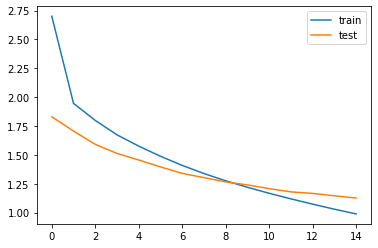

In [34]:
from matplotlib import pyplot
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

In [35]:
from keras.wrappers.scikit_learn import KerasClassifier
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
seed = 1000

# generic function to plot the train Vs validation loss/accuracy:
def plot_history(history):
    loss_list = [s for s in history.history.keys() if 'loss' in s and 'val' not in s]
    val_loss_list = [s for s in history.history.keys() if 'loss' in s and 'val' in s]
    acc_list = [s for s in history.history.keys() if 'acc' in s and 'val' not in s]
    val_acc_list = [s for s in history.history.keys() if 'acc' in s and 'val' in s]
    if len(loss_list) == 0:
        print('Loss is missing in history')
        return 
    ## As loss always exists
    epochs = range(1,len(history.history[loss_list[0]]) + 1)
    plt.figure(figsize=(25,15))
    ## Accuracy
    plt.subplot(2,2,1)
    for l in acc_list:
        plt.plot(epochs, history.history[l], 'b', label='Training accuracy (' + str(format(history.history[l][-1],'.4f'))+')')
    for l in val_acc_list:    
        plt.plot(epochs, history.history[l], 'g', label='Validation accuracy (' + str(format(history.history[l][-1],'.4f'))+')')

    plt.title('Training Accuracy Vs Validation Accuracy\n')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    ## Loss
    plt.subplot(2,2,2)
    for l in loss_list:
        plt.plot(epochs, history.history[l], 'b', label='Training loss (' + str(str(format(history.history[l][-1],'.4f'))+')'))
    for l in val_loss_list:
        plt.plot(epochs, history.history[l], 'g', label='Validation loss (' + str(str(format(history.history[l][-1],'.4f'))+')'))
    
    plt.title('Training Loss Vs Validation Loss\n')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

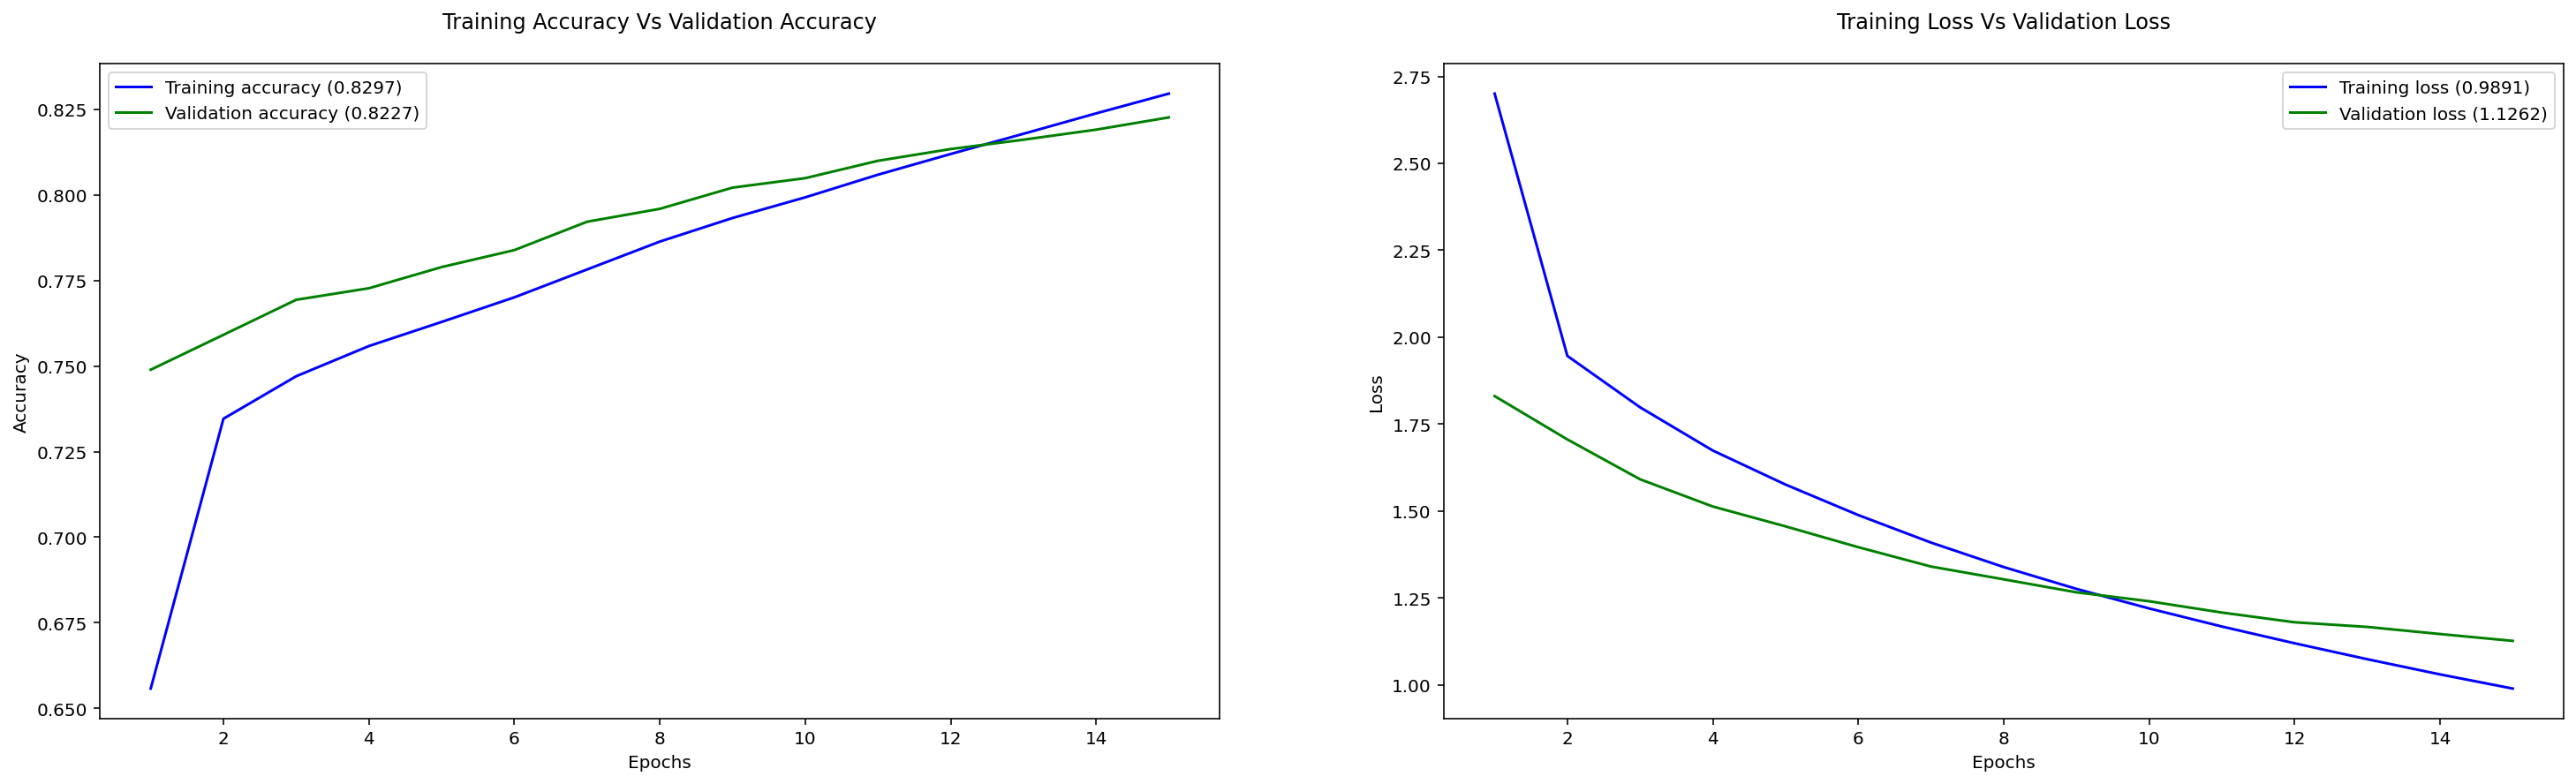

In [36]:
plot_history(history)

In [37]:
reverse_target_word_index = sql_tokenizer.index_word
reverse_source_word_index = eng_tokenizer.index_word
target_word_index = sql_tokenizer.word_index

In [38]:
# Encode the input sequence to get the feature vector
# encoder model input and output are taken directly from the model
encoder_model = Model(encoder_inputs, encoder_states)

# Decoder setup
decoder_state_input_h = Input(shape=(latent_dim,))
decoder_state_input_c = Input(shape=(latent_dim,))
decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]

# Get the embeddings of the decoder sequence
dec_emb2 = dec_emb_layer(decoder_inputs)

# To predict the next word in the sequence, 
# set the initial states to the states from the previous time step
decoder_outputs2, state_h2, state_c2 = decoder_lstm(dec_emb2, 
                                                    initial_state=decoder_states_inputs)
decoder_states2 = [state_h2, state_c2]

# A dense softmax layer to generate prob dist. over the target vocabulary
decoder_outputs2 = decoder_dense(decoder_outputs2) 

# Final decoder model
decoder_model = Model(
    [decoder_inputs] + decoder_states_inputs,
    [decoder_outputs2] + decoder_states2)

In [39]:
decoder_model.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, None)]       0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, None, 300)    4287000     input_2[0][0]                    
__________________________________________________________________________________________________
input_3 (InputLayer)            [(None, 300)]        0                                            
__________________________________________________________________________________________________
input_4 (InputLayer)            [(None, 300)]        0                                            
____________________________________________________________________________________________

In [49]:
def decode_sequence(input_seq):
    # Encode the input as state vectors.
    e_h, e_c = encoder_model.predict(input_seq)
    
    # Generate empty target sequence of length 1.
    target_seq = np.zeros((1,1))
    
    # Populate the first character of target sequence with the start word.
    target_seq[0, 0] = target_word_index['start']

    # Sampling loop for a batch of sequences
    # (to simplify, here we assume a batch of size 1).
    stop_condition = False
    decoded_sentence = ''
    while not stop_condition:
        output_tokens, h, c = decoder_model.predict([target_seq] + [e_h, e_c])

        # Sample a token
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_token = reverse_target_word_index[sampled_token_index]

        if(sampled_token!='end'):
            decoded_sentence += ' '+sampled_token
            
        # Exit condition: either hit max length or find stop word.
        if (sampled_token == 'end' or len(decoded_sentence.split()) >= (max_length_tar-1)):
            stop_condition = True

        # Update the target sequence (of length 1).
        target_seq = np.zeros((1,1))
        target_seq[0, 0] = sampled_token_index

        # Update states
        e_h, e_c = [h, c]

    return decoded_sentence

In [50]:
# eng2text and sql2text functions to get the original sentence
def eng2text(input_seq):
    newString=''
    for i in input_seq:
        if(i!=0):
            newString=newString+reverse_source_word_index[i]+' '
    return newString

def sql2text(input_seq):
    newString=''
    for i in input_seq:
        if(i!=0):
            newString=newString+reverse_target_word_index[i]+' '
    return newString

In [51]:
for i in range(0,10):
    print("English Sentence: ",eng2text(x_tr[i]))
    print('Actual SQL Query:', sql2text(y_tr[i]))
    print("Predicted SQL Query: ",decode_sequence(x_tr[i].reshape(1,max_length_src)))
    print("\n")

English Sentence:  what's the smallest amount of laps that had a finish of 7 with a start of 6 
Actual SQL Query: start select min laps from table where finish 7 and start 6 end 
Predicted SQL Query:   select min laps from table where time retired 1


English Sentence:  which route has a date of 2 july 
Actual SQL Query: start select route from table where date 2 july end 
Predicted SQL Query:   select format from table where catalog 2


English Sentence:  in the western oval venue what is the average crowd 
Actual SQL Query: start select avg crowd from table where venue western oval end 
Predicted SQL Query:   select crowd from table where venue junction oval


English Sentence:  what is the score for set 3 with a time at 15 04 
Actual SQL Query: start select set 3 from table where time 15 04 end 
Predicted SQL Query:   select set 3 from table where set 3 00 25


English Sentence:  what is the name when the transfer fee is loan 
Actual SQL Query: start select name from table where tra

In [52]:
input_text = 'find average marks of the students'
ip_seq = eng_tokenizer.texts_to_sequences([input_text])
ip_padding = pad_sequences(ip_seq,  maxlen=max_length_src, padding='post')
print("English Sentence: ", input_text)
print("SQL Query: ", decode_sequence(ip_padding[0].reshape(1,max_length_src)))

English Sentence:  find average marks of the students
SQL Query:   select avg capacity from table where team nickname
